cell 0 


In [ ]:
# Cell 0 — Setup (imports, paths, seeds, dirs)

# ---- Core imports for data & training ----
import os, json, time, hashlib
from pathlib import Path


import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

# Optional: if you still want to compare with python_speech_features
# from python_speech_features import mfcc as psf_mfcc

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ---- Reproducibility (use one seed everywhere) ----
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---- Project paths (works whether notebook is in Notebooks/ or not) ----
cwd = Path.cwd()
nb_names = {"Notebooks", "notebooks"}
PROJECT_ROOT = cwd.parent if cwd.name in nb_names else cwd

# Point to your dataset (adjust if needed)
AUDIO_ROOT = PROJECT_ROOT / "0_dB_fan" / "fan" / "id_00"     # contains normal/ and abnormal/
FEAT_DIR   = PROJECT_ROOT / "features"                       # raw features cache
PAD_DIR    = PROJECT_ROOT / "features_padded"                # padded/normalized features cache
MODEL_DIR  = PROJECT_ROOT / "model"                          # saved models & histories

# Create dirs if missing
for d in (FEAT_DIR, PAD_DIR, MODEL_DIR):
    d.mkdir(parents=True, exist_ok=True)

# ---- Default audio / MFCC parameters (edit later if you like) ----
SAMPLE_RATE     = 16000
CHUNK_DURATION  = 1.0     # seconds per chunk
N_MFCC          = 13
N_FILT          = 26
N_FFT           = 1024     # if you use python_speech_features

# Small sanity print so you always see where you are
print("PROJECT_ROOT:", PROJECT_ROOT)
print("AUDIO_ROOT  :", AUDIO_ROOT)
print("Dirs exist?  :", FEAT_DIR.exists(), PAD_DIR.exists(), MODEL_DIR.exists())
print("Seed         :", SEED)


c:\Users\hichr\OneDrive\Desktop\Internship\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\hichr\OneDrive\Desktop\Internship\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\hichr\OneDrive\Desktop\Internship\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.pr

PROJECT_ROOT: c:\Users\hichr\OneDrive\Desktop\Internship
AUDIO_ROOT  : c:\Users\hichr\OneDrive\Desktop\Internship\0_dB_fan\fan\id_00
Dirs exist?  : True True True
Seed         : 42


cell 1 : load dataset 


In [2]:
files, labels = [], []
for lab in ["normal", "abnormal"]:
    folder = AUDIO_ROOT / lab
    if not folder.exists():
        print(f"Warning: {folder} not found")
        continue
    for f in folder.glob("*.wav"):
        files.append(str(f))
        labels.append(0 if lab == "normal" else 1)


df = pd.DataFrame({"filename": files, "label": labels}).sort_values("filename").reset_index(drop=True)
print("Dataset loaded:", len(df), "files")
len(df), df.head()


Dataset loaded: 1418 files


(1418,
                                             filename  label
 0  c:\Users\hichr\OneDrive\Desktop\Internship\0_d...      1
 1  c:\Users\hichr\OneDrive\Desktop\Internship\0_d...      1
 2  c:\Users\hichr\OneDrive\Desktop\Internship\0_d...      1
 3  c:\Users\hichr\OneDrive\Desktop\Internship\0_d...      1
 4  c:\Users\hichr\OneDrive\Desktop\Internship\0_d...      1)

cell 2 : extract mell spectogram

In [4]:
# === Cell 2: Extract log Mel-spectrogram features for each audio ===
import sys 
# --- Mel-spectrogram parameters ---
n_mels = 64         # Number of Mel bands
frames = 5          # How many frames to concatenate into a single vector
n_fft = 1024
hop_length = 512
power = 2.0

feature_vectors = []
failed_files = []

for file in tqdm(df["filename"], desc="Extracting features"):
    try:
        # Load audio
        y, sr = librosa.load(file, sr=SAMPLE_RATE)
        
        # Compute mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
            n_mels=n_mels, power=power
        )

        # Convert to log scale
        log_mel_spec = 20.0 / power * np.log10(mel_spec + sys.float_info.epsilon)

        # Frame slicing
        vec_size = log_mel_spec.shape[1] - frames + 1
        dims = n_mels * frames

        if vec_size < 1:
            feature_vectors.append(np.empty((0, dims), float))
            continue

        vectorarray = np.zeros((vec_size, dims), float)
        for t in range(frames):
            vectorarray[:, n_mels * t : n_mels * (t + 1)] = log_mel_spec[:, t : t + vec_size].T

        feature_vectors.append(vectorarray)

    except Exception as e:
        print(f"❌ Failed on {file}: {e}")
        failed_files.append(file)

# Join all feature chunks
X = np.vstack(feature_vectors)
y = np.repeat(df["label"].values, [fv.shape[0] for fv in feature_vectors])

print("✅ Feature extraction complete.")
print("X shape:", X.shape)
print("y shape:", y.shape)


Extracting features: 100%|██████████| 1418/1418 [00:14<00:00, 100.12it/s]


✅ Feature extraction complete.
X shape: (438162, 320)
y shape: (438162,)


 cell 3 : spliit data 

In [5]:
# === Cell 3: Split into Train, Validation, and Test ===

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Normalize features (recommended for CNNs)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Split → Train (70%), Val (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=SEED, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

# Final shapes
print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (306713, 320) (306713,)
Val  : (65724, 320) (65724,)
Test : (65725, 320) (65725,)


 cell 4 : model build ; 

In [12]:
# === Cell 4A: Static setup (run once) ===

import os, time, json
import numpy as np
from pathlib import Path
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set seed for reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Create model directory if needed
MODEL_DIR = Path.cwd() / "model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# === Cell 4B: Model parameters, training, and evaluation ===

# Define model hyperparameters
params = {
    "f1": 32,
    "f2": 64,
    "k1": 5,
    "k2": 3,
    "dense": 64,
    "lr": 1e-3,
    "l2": 0.0,
    "epochs": 30,
    "batch_size": 64,
}

# Prepare model input shape
input_shape = (X_train.shape[1], 1)  # We will reshape X later
uniq = np.unique(y_train)
n_classes = 1 if len(uniq) == 2 and set(uniq).issubset({0, 1}) else len(uniq)

# Build the model
model = Sequential([
    layers.Input(shape=input_shape),

    layers.Conv1D(params["f1"], params["k1"], padding="same", activation="relu"),
    layers.MaxPooling1D(2),

    layers.Conv1D(params["f2"], params["k2"], padding="same", activation="relu"),
    layers.MaxPooling1D(2),

    layers.GlobalAveragePooling1D(),
    layers.Dense(params["dense"], activation="relu"),

    layers.Dense(1 if n_classes == 1 else n_classes,
                 activation="sigmoid" if n_classes == 1 else "softmax")
])

# Compile the model
loss = "binary_crossentropy" if n_classes == 1 else "sparse_categorical_crossentropy"
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=params["lr"]),
    loss=loss,
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# Reshape data for Conv1D
X_train_r = X_train[..., np.newaxis]
X_val_r = X_val[..., np.newaxis]
X_test_r = X_test[..., np.newaxis]

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Set up callbacks
run_id = time.strftime("melcnn_%Y%m%d-%H%M%S")
ckpt_path = MODEL_DIR / f"best_melcnn_{run_id}.keras"
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=str(ckpt_path), monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
]

# Train the model
history = model.fit(
    X_train_r, y_train,
    validation_data=(X_val_r, y_val),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    class_weight=class_weight_dict,
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

# Evaluate on test set
test_metrics = model.evaluate(X_test_r, y_test, verbose=0)
print("\n✅ Test metrics:", dict(zip(model.metrics_names, test_metrics)))

# Save training history
hist_path = MODEL_DIR / f"train_history_{run_id}.json"
with open(hist_path, "w", encoding="utf-8") as f:
    json.dump({
        "history": history.history,
        "params": params,
        "test_metrics": dict(zip(model.metrics_names, test_metrics)),
    }, f, indent=2)

print(f"\n📁 Saved training history to: {hist_path}")
print(f"📁 Best model checkpoint saved to: {ckpt_path}")


Epoch 1/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.7041 - auc: 0.7560 - loss: 0.5726 - val_accuracy: 0.8115 - val_auc: 0.8354 - val_loss: 0.4352 - learning_rate: 0.0010
Epoch 2/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.7804 - auc: 0.8436 - loss: 0.4745 - val_accuracy: 0.8332 - val_auc: 0.8666 - val_loss: 0.3913 - learning_rate: 0.0010
Epoch 3/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.7980 - auc: 0.8663 - loss: 0.4442 - val_accuracy: 0.8429 - val_auc: 0.8816 - val_loss: 0.3706 - learning_rate: 0.0010
Epoch 4/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.8087 - auc: 0.8800 - loss: 0.4238 - val_accuracy: 0.8493 - val_auc: 0.8935 - val_loss: 0.3562 - learning_rate: 0.0010
Epoch 5/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8178 - auc: 0.8905 - loss: 0.4071 - val_accuracy: 0.8529 - val_auc: 0.9020 - val_loss: 0.3458 - learning_rate: 0.0010
Epoch 6/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy

🔍 Best F1 (VAL) = 0.8060 at threshold = 0.483
VAL PR-AUC (Average Precision): 0.9016


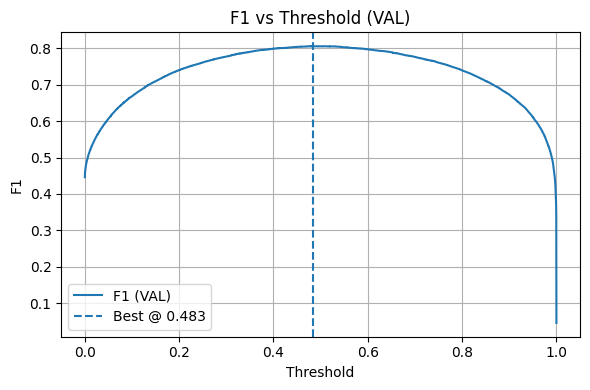


✅ TEST @ threshold = 0.483
Confusion Matrix:
 [[43287  3573]
 [ 3832 15033]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9187    0.9238    0.9212     46860
           1     0.8080    0.7969    0.8024     18865

    accuracy                         0.8873     65725
   macro avg     0.8633    0.8603    0.8618     65725
weighted avg     0.8869    0.8873    0.8871     65725

ROC-AUC (TEST): 0.9453359466406579
PR-AUC (TEST) : 0.9011023360218964


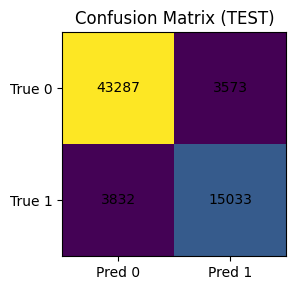

In [13]:
# === Cell — Easy metrics, thresholding, and plots ===
from sklearn.metrics import (
    precision_recall_curve, classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)
import matplotlib.pyplot as plt
import numpy as np

# --- 1) Get probabilities on VAL / TEST ---
# Works for: sigmoid (1 unit) or softmax (2 units). If >2 classes, we fall back to argmax flow.
def probs_from_model(m, X, y_ref=None):
    p = m.predict(X, verbose=0)
    if p.ndim == 1 or p.shape[1] == 1:
        return p.ravel()  # sigmoid
    # softmax: if binary, use column 1 as "positive" prob, else return None to trigger multiclass path
    if y_ref is not None and len(np.unique(y_ref)) == 2 and p.shape[1] == 2:
        return p[:, 1].ravel()
    return None  # multiclass

y_val_proba  = probs_from_model(model, X_val_r, y_val)
y_test_proba = probs_from_model(model, X_test_r, y_test)

# --- 2) Binary path: pick best F1 threshold on VAL, then evaluate on TEST ---
if y_val_proba is not None:
    # 2A) Best F1 threshold on VAL
    prec, rec, thr = precision_recall_curve(y_val, y_val_proba)   # thr len = len(prec)-1
    f1 = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9)
    best_idx = int(np.argmax(f1))
    best_thr = float(thr[best_idx])

    print(f"🔍 Best F1 (VAL) = {f1[best_idx]:.4f} at threshold = {best_thr:.3f}")
    print(f"VAL PR-AUC (Average Precision): {average_precision_score(y_val, y_val_proba):.4f}")

    # 2B) Plot F1 vs Threshold
    plt.figure(figsize=(6,4))
    plt.plot(thr, f1, label="F1 (VAL)")
    plt.axvline(best_thr, linestyle="--", label=f"Best @ {best_thr:.3f}")
    plt.xlabel("Threshold"); plt.ylabel("F1"); plt.title("F1 vs Threshold (VAL)")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    # 2C) Evaluate on TEST at chosen threshold
    use_thr = best_thr
    y_test_pred = (y_test_proba >= use_thr).astype(int)

    print("\n✅ TEST @ threshold =", round(use_thr, 3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred, digits=4))
    print("ROC-AUC (TEST):", roc_auc_score(y_test, y_test_proba))
    print("PR-AUC (TEST) :", average_precision_score(y_test, y_test_proba))

    # 2D) Pretty confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix (TEST)")
    plt.xticks([0,1], ["Pred 0","Pred 1"])
    plt.yticks([0,1], ["True 0","True 1"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]), ha="center", va="center")
    plt.tight_layout(); plt.show()

# --- 3) Multiclass fallback (no thresholding) ---
else:
    y_val_prob_full  = model.predict(X_val_r,  verbose=0)
    y_test_prob_full = model.predict(X_test_r, verbose=0)
    y_val_pred  = np.argmax(y_val_prob_full,  axis=1)
    y_test_pred = np.argmax(y_test_prob_full, axis=1)

    print("✅ Multiclass evaluation (argmax):")
    print("Confusion Matrix (TEST):\n", confusion_matrix(y_test, y_test_pred))
    print("\nClassification Report (TEST):\n", classification_report(y_test, y_test_pred, digits=4))

    # Simple confusion matrix plot
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix (TEST)")
    ticks = np.arange(len(np.unique(y_test)))
    plt.xticks(ticks, [f"Pred {t}" for t in ticks])
    plt.yticks(ticks, [f"True {t}" for t in ticks])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]), ha="center", va="center")
    plt.tight_layout(); plt.show()


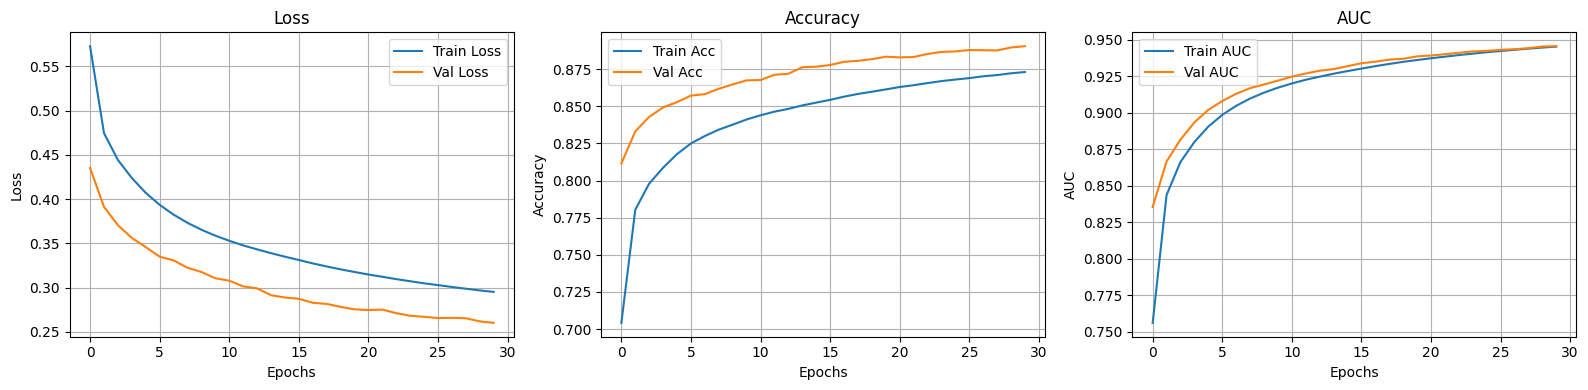

In [14]:
import matplotlib.pyplot as plt

# Extract history
hist = history.history

# Plot training & validation loss
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(hist["loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(hist["accuracy"], label="Train Acc")
plt.plot(hist["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(hist["auc"], label="Train AUC")
plt.plot(hist["val_auc"], label="Val AUC")
plt.title("AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# === Cell 4A: Static setup (run once) ===

import os, time, json
import numpy as np
from pathlib import Path
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set seed for reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Create model directory if needed
MODEL_DIR = Path.cwd() / "model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# === Phase 1 — Improved CNN Model ===

# Updated hyperparameters
params = {
    "f1": 64,
    "f2": 128,
    "f3": 256,        # NEW
    "k1": 5,
    "k2": 3,
    "k3": 3,          # NEW
    "dense": 64,
    "lr": 1e-3,
    "l2": 0.0,
    "epochs": 30,
    "batch_size": 64,
    "dropout": 0.05    # NEW
}

# Input shape
input_shape = (X_train.shape[1], 1)
uniq = np.unique(y_train)
n_classes = 1 if len(uniq) == 2 and set(uniq).issubset({0, 1}) else len(uniq)

# Build improved model
model = Sequential([
    layers.Input(shape=input_shape),

    layers.Conv1D(params["f1"], params["k1"], padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),

    layers.Conv1D(params["f2"], params["k2"], padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),

    layers.Conv1D(params["f3"], params["k3"], padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),

    layers.Dense(params["dense"], activation="relu"),
    layers.Dropout(params["dropout"]),

    layers.Dense(1 if n_classes == 1 else n_classes,
                 activation="sigmoid" if n_classes == 1 else "softmax")
])

# Compile the model
loss = "binary_crossentropy" if n_classes == 1 else "sparse_categorical_crossentropy"
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=params["lr"]),
    loss=loss,
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# Reshape data for Conv1D
X_train_r = X_train[..., np.newaxis]
X_val_r = X_val[..., np.newaxis]
X_test_r = X_test[..., np.newaxis]

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Set up callbacks
run_id = time.strftime("melcnn_%Y%m%d-%H%M%S")
ckpt_path = MODEL_DIR / f"best_melcnn_{run_id}.keras"
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=str(ckpt_path), monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
]

# Train the model
history = model.fit(
    X_train_r, y_train,
    validation_data=(X_val_r, y_val),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    class_weight=class_weight_dict,
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

# Evaluate on test set
test_metrics = model.evaluate(X_test_r, y_test, verbose=0)
print("\n✅ Test metrics:", dict(zip(model.metrics_names, test_metrics)))

# Save training history
hist_path = MODEL_DIR / f"train_history_{run_id}.json"
with open(hist_path, "w", encoding="utf-8") as f:
    json.dump({
        "history": history.history,
        "params": params,
        "test_metrics": dict(zip(model.metrics_names, test_metrics)),
    }, f, indent=2)

print(f"\n📁 Saved training history to: {hist_path}")
print(f"📁 Best model checkpoint saved to: {ckpt_path}")


Epoch 1/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 431s 90ms/step - accuracy: 0.8698 - auc: 0.9425 - loss: 0.3039 - val_accuracy: 0.9145 - val_auc: 0.9681 - val_loss: 0.2068 - learning_rate: 0.0010
Epoch 2/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 320s 67ms/step - accuracy: 0.9142 - auc: 0.9728 - loss: 0.2107 - val_accuracy: 0.9029 - val_auc: 0.9732 - val_loss: 0.2240 - learning_rate: 0.0010
Epoch 3/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 161s 34ms/step - accuracy: 0.9300 - auc: 0.9813 - loss: 0.1747 - val_accuracy: 0.9301 - val_auc: 0.9803 - val_loss: 0.1676 - learning_rate: 0.0010
Epoch 4/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 170s 36ms/step - accuracy: 0.9417 - auc: 0.9865 - loss: 0.1477 - val_accuracy: 0.9446 - val_auc: 0.9853 - val_loss: 0.1388 - learning_rate: 0.0010
Epoch 5/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 200s 35ms/step - accuracy: 0.9502 - auc: 0.9900 - loss: 0.1266 - val_accuracy: 0.9470 - val_auc: 0.9880 - val_loss: 0.1344 - learning_rate: 0.0010
Epoch 6/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 175s 37ms/ste

In [16]:
# === Cell 4A: Static setup (run once) ===

import os, time, json
import numpy as np
from pathlib import Path
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set seed for reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Create model directory if needed
MODEL_DIR = Path.cwd() / "model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# === Phase 1 — Improved CNN Model ===

# Updated hyperparameters
params = {
    "f1": 64,
    "f2": 128,
    "f3": 256,        # NEW
    "k1": 5,
    "k2": 3,
    "k3": 3,          # NEW
    "dense": 64,
    "lr": 1e-3,
    "l2": 0.0,
    "epochs": 30,
    "batch_size": 64,
    "dropout": 0.1    # NEW
}

# Input shape
input_shape = (X_train.shape[1], 1)
uniq = np.unique(y_train)
n_classes = 1 if len(uniq) == 2 and set(uniq).issubset({0, 1}) else len(uniq)

# Build improved model
model = Sequential([
    layers.Input(shape=input_shape),

    layers.Conv1D(params["f1"], params["k1"], padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),

    layers.Conv1D(params["f2"], params["k2"], padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),

    layers.Conv1D(params["f3"], params["k3"], padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),

    layers.Dense(params["dense"], activation="relu"),
    layers.Dropout(params["dropout"]),

    layers.Dense(1 if n_classes == 1 else n_classes,
                 activation="sigmoid" if n_classes == 1 else "softmax")
])

# Compile the model
loss = "binary_crossentropy" if n_classes == 1 else "sparse_categorical_crossentropy"
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=params["lr"]),
    loss=loss,
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# Reshape data for Conv1D
X_train_r = X_train[..., np.newaxis]
X_val_r = X_val[..., np.newaxis]
X_test_r = X_test[..., np.newaxis]

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Set up callbacks
run_id = time.strftime("melcnn_%Y%m%d-%H%M%S")
ckpt_path = MODEL_DIR / f"best_melcnn_{run_id}.keras"
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=str(ckpt_path), monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
]

# Train the model
history = model.fit(
    X_train_r, y_train,
    validation_data=(X_val_r, y_val),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    class_weight=class_weight_dict,
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

# Evaluate on test set
test_metrics = model.evaluate(X_test_r, y_test, verbose=0)
print("\n✅ Test metrics:", dict(zip(model.metrics_names, test_metrics)))

# Save training history
hist_path = MODEL_DIR / f"train_history_{run_id}.json"
with open(hist_path, "w", encoding="utf-8") as f:
    json.dump({
        "history": history.history,
        "params": params,
        "test_metrics": dict(zip(model.metrics_names, test_metrics)),
    }, f, indent=2)

print(f"\n📁 Saved training history to: {hist_path}")
print(f"📁 Best model checkpoint saved to: {ckpt_path}")


Epoch 1/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 170s 35ms/step - accuracy: 0.8738 - auc: 0.9464 - loss: 0.2936 - val_accuracy: 0.9009 - val_auc: 0.9672 - val_loss: 0.2354 - learning_rate: 0.0010
Epoch 2/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 179s 37ms/step - accuracy: 0.9179 - auc: 0.9754 - loss: 0.2003 - val_accuracy: 0.9006 - val_auc: 0.9757 - val_loss: 0.2388 - learning_rate: 0.0010
Epoch 3/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 194s 40ms/step - accuracy: 0.9349 - auc: 0.9840 - loss: 0.1615 - val_accuracy: 0.9271 - val_auc: 0.9816 - val_loss: 0.1796 - learning_rate: 0.0010
Epoch 4/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 230s 48ms/step - accuracy: 0.9470 - auc: 0.9891 - loss: 0.1330 - val_accuracy: 0.9355 - val_auc: 0.9863 - val_loss: 0.1621 - learning_rate: 0.0010
Epoch 5/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 251s 52ms/step - accuracy: 0.9559 - auc: 0.9923 - loss: 0.1106 - val_accuracy: 0.9505 - val_auc: 0.9888 - val_loss: 0.1257 - learning_rate: 0.0010
Epoch 6/30
4793/4793 ━━━━━━━━━━━━━━━━━━━━ 382s 80ms/ste

In [17]:
print("Metrics names:", model.metrics_names)
test_out = model.evaluate(X_test_r, y_test, verbose=0)
print("Raw evaluate output:", test_out)
print({k: v for k, v in zip(model.metrics_names, test_out)})


Metrics names: ['loss', 'compile_metrics']
Raw evaluate output: [0.06163761392235756, 0.9840700030326843, 0.9951701760292053]
{'loss': 0.06163761392235756, 'compile_metrics': 0.9840700030326843}


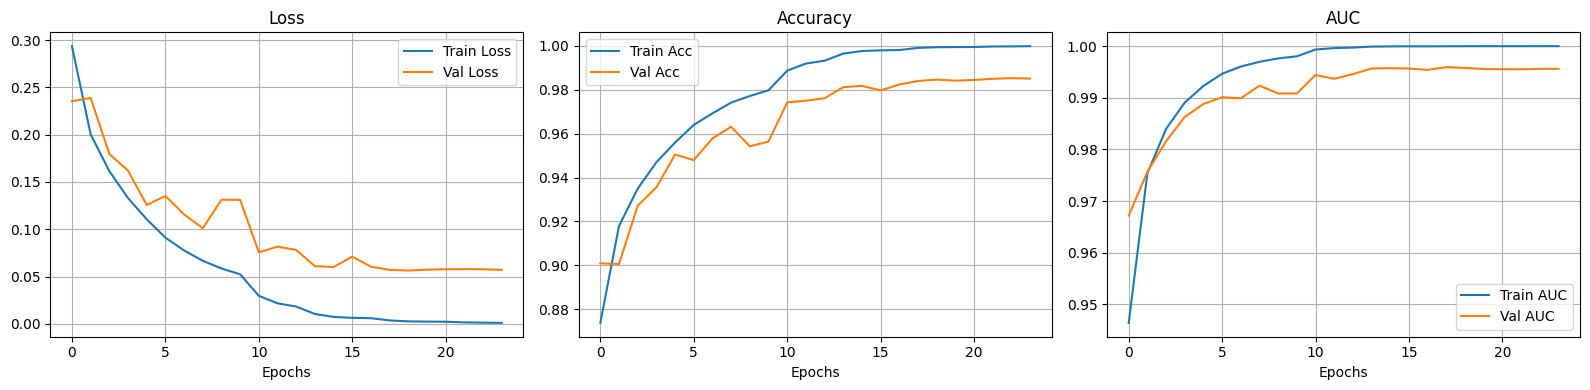

In [18]:
import matplotlib.pyplot as plt

hist = history.history

plt.figure(figsize=(16,4))
# Loss
plt.subplot(1,3,1)
plt.plot(hist["loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.title("Loss"); plt.xlabel("Epochs"); plt.legend(); plt.grid(True)

# Accuracy
plt.subplot(1,3,2)
plt.plot(hist["accuracy"], label="Train Acc")
plt.plot(hist["val_accuracy"], label="Val Acc")
plt.title("Accuracy"); plt.xlabel("Epochs"); plt.legend(); plt.grid(True)

# AUC (if recorded)
if "auc" in hist and "val_auc" in hist:
    plt.subplot(1,3,3)
    plt.plot(hist["auc"], label="Train AUC")
    plt.plot(hist["val_auc"], label="Val AUC")
    plt.title("AUC"); plt.xlabel("Epochs"); plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()


Class balance (TEST): {np.int64(0): np.int64(46860), np.int64(1): np.int64(18865)}
Best F1(VAL)=0.9735 @ thr=0.570
VAL PR-AUC (AP): 0.9967858095376434


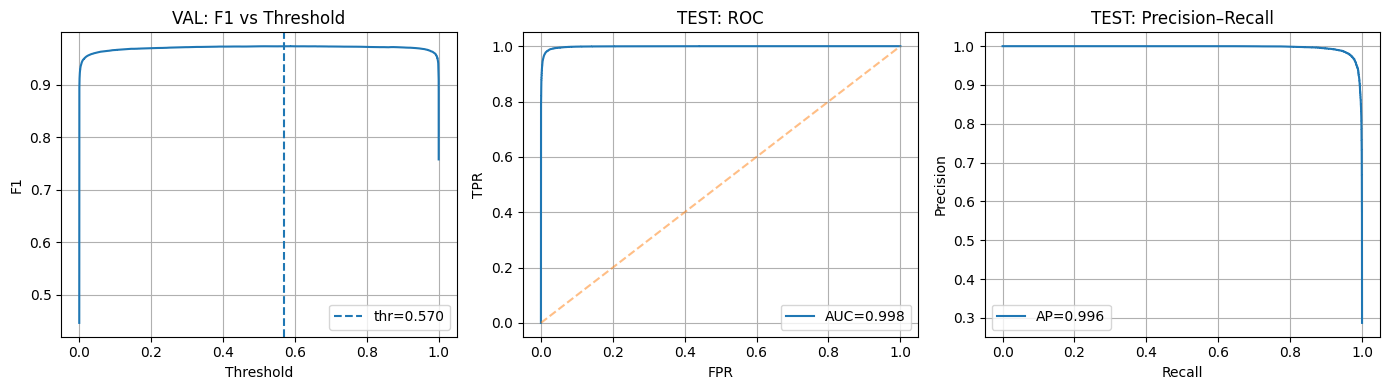


TEST @ thr = 0.57
Confusion Matrix:
 [[46308   552]
 [  486 18379]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9896    0.9882    0.9889     46860
           1     0.9708    0.9742    0.9725     18865

    accuracy                         0.9842     65725
   macro avg     0.9802    0.9812    0.9807     65725
weighted avg     0.9842    0.9842    0.9842     65725

ROC-AUC(TEST): 0.9984277656720103  | PR-AUC(TEST): 0.9964535949917285


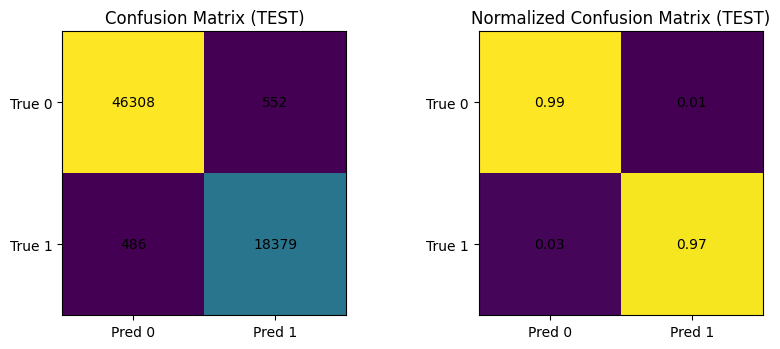

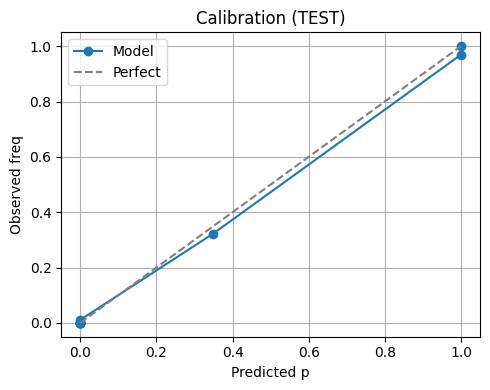

In [19]:
from sklearn.metrics import (
    precision_recall_curve, classification_report, confusion_matrix,
    roc_auc_score, average_precision_score, roc_curve
)
from sklearn.calibration import calibration_curve
import numpy as np, matplotlib.pyplot as plt

# --- helpers ---
def probs_from_model(m, X, y_ref=None):
    p = m.predict(X, verbose=0)
    if p.ndim == 1 or (p.ndim == 2 and p.shape[1] == 1):  # sigmoid
        return p.ravel()
    if y_ref is not None and len(np.unique(y_ref)) == 2 and p.shape[1] == 2:  # softmax-binary
        return p[:,1].ravel()
    return None

def plot_cm(cm, labels, title, normalize=False):
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1e-12)
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xticks(range(len(labels)), [f"Pred {l}" for l in labels])
    plt.yticks(range(len(labels)), [f"True {l}" for l in labels])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{cm[i,j]:.2f}" if normalize else f"{int(cm[i,j])}"
            plt.text(j, i, txt, ha="center", va="center")
    plt.tight_layout()

# --- data ---
y_val  = np.asarray(y_val).ravel()
y_test = np.asarray(y_test).ravel()
y_val_proba  = probs_from_model(model, X_val_r,  y_val)
y_test_proba = probs_from_model(model, X_test_r, y_test)

print("Class balance (TEST):", dict(zip(*np.unique(y_test, return_counts=True))))

# --- best-F1 threshold from VAL ---
prec_v, rec_v, thr_v = precision_recall_curve(y_val, y_val_proba)
f1_v = 2*(prec_v[:-1]*rec_v[:-1])/(prec_v[:-1]+rec_v[:-1]+1e-9)
best_idx = int(np.argmax(f1_v))
best_thr = float(thr_v[best_idx])
print(f"Best F1(VAL)={f1_v[best_idx]:.4f} @ thr={best_thr:.3f}")
print("VAL PR-AUC (AP):", average_precision_score(y_val, y_val_proba))

# --- plots: F1-threshold, ROC/PR on TEST ---
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(thr_v, f1_v); plt.axvline(best_thr, ls='--', label=f"thr={best_thr:.3f}")
plt.title("VAL: F1 vs Threshold"); plt.xlabel("Threshold"); plt.ylabel("F1")
plt.grid(True); plt.legend()

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)
plt.subplot(1,3,2)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],'--',alpha=.5)
plt.title("TEST: ROC"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.grid(True); plt.legend()

prec_t, rec_t, _ = precision_recall_curve(y_test, y_test_proba)
ap = average_precision_score(y_test, y_test_proba)
plt.subplot(1,3,3)
plt.plot(rec_t, prec_t, label=f"AP={ap:.3f}")
plt.title("TEST: Precision–Recall"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

# --- confusion matrices at chosen threshold ---
y_test_pred = (y_test_proba >= best_thr).astype(int)
cm = confusion_matrix(y_test, y_test_pred)
print("\nTEST @ thr =", round(best_thr,3))
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, digits=4))
print("ROC-AUC(TEST):", roc_auc, " | PR-AUC(TEST):", ap)

labels = sorted(np.unique(y_test))
plt.figure(figsize=(10,3.6))
plt.subplot(1,2,1); plot_cm(cm, labels, "Confusion Matrix (TEST)", normalize=False)
plt.subplot(1,2,2); plot_cm(cm, labels, "Normalized Confusion Matrix (TEST)", normalize=True)
plt.show()

# --- calibration curve ---
prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=15, strategy="quantile")
plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1],[0,1],'--', color='gray', label="Perfect")
plt.title("Calibration (TEST)"); plt.xlabel("Predicted p"); plt.ylabel("Observed freq")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
